# LegacyHalos Sample Selection

The goal of this notebook is to select a sample of central and satellite galaxies from redMaPPer but with (deeper) Legacy Survey photometry from DR6 + DR7.

The input (row-matched) catalogs for the centrals are:
* \$REDMAPPER_DIR/v6.3.1/dr8_run_redmapper_v6.3.1_lgt5_catalog.fit  
* \$REDMAPPER_DIR/v6.3.1/redmapper-v6.3.1-lgt5-centrals-sdssWISEphot-dr14.fits (generated by [redmapper-sdssWISEphot.ipynb](https://github.com/moustakas/legacyhalos/tree/master/doc/redmapper-sdssWISEphot.ipynb))  
* \$REDMAPPER_DIR/v6.3.1/legacysurvey-dr6-centrals-v6.3.1.fits (generated by [match-legacysurvey-redmapper.slurm](https://github.com/moustakas/legacyhalos/tree/master/bin/match-legacysurvey-redmapper.slurm))  
* \$REDMAPPER_DIR/v6.3.1/legacysurvey-dr7-centrals-v6.3.1.fits (generated by [match-legacysurvey-redmapper.slurm](https://github.com/moustakas/legacyhalos/tree/master/bin/match-legacysurvey-redmapper.slurm))  


and for the satellites:
* \$REDMAPPER_DIR/v6.3.1/dr8_run_redmapper_v6.3.1_lgt5_catalog_members.fit
* \$REDMAPPER_DIR/v6.3.1/redmapper-v6.3.1-lgt5-members-sdssWISEphot-dr14.fits (generated by [redmapper-sdssWISEphot.ipynb](https://github.com/moustakas/legacyhalos/tree/master/doc/redmapper-sdssWISEphot.ipynb))  
* \$REDMAPPER_DIR/v6.3.1/legacysurvey-dr6-members-v6.3.1.fits (generated by [match-legacysurvey-redmapper.slurm](https://github.com/moustakas/legacyhalos/tree/master/bin/match-legacysurvey-redmapper.slurm))
* \$REDMAPPER_DIR/v6.3.1/legacysurvey-dr7-members-v6.3.1.fits (generated by [match-legacysurvey-redmapper.slurm](https://github.com/moustakas/legacyhalos/tree/master/bin/match-legacysurvey-redmapper.slurm))

And the resulting output catalogs are the files:

* \$LEGACYHALOS_DIR/sample/legacyhalos-centrals-dr6-dr7.fits
* \$LEGACYHALOS_DIR/sample/legacyhalos-allcentrals-dr6-dr7.fits
* \$LEGACYHALOS_DIR/sample/legacyhalos-satellites-dr6-dr7.fits

In addition, we create jackknife subsamples of the data and write them out in the file:

* \$LEGACYHALOS_DIR/sample/legacyhalos-jackknife-dr6-dr7.fits

### Imports

In [1]:
import os, warnings, pdb, time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import healpy as hp
import fitsio
from astropy.io import fits
from astropy.table import Table, Column, vstack, hstack
import astropy.units as u
from astropy.coordinates import SkyCoord

In [3]:
import legacyhalos.io
from legacyhalos.misc import radec2pix, pix2radec

In [4]:
import seaborn as sns
%matplotlib inline

In [5]:
#index = np.arange(50000)
index = None

### Specify the LegacyHalos path and output files names.

In [6]:
legacyhalos_dir = legacyhalos.io.legacyhalos_dir()
if not os.path.exists(legacyhalos_dir):
    os.makedirs(legacyhalos_dir)

In [7]:
lsdr, sdssdr, rmversion = 'dr6-dr7', 'dr14', 'v6.3.1'

In [8]:
cenfile = os.path.join( legacyhalos.io.sample_dir(), 'legacyhalos-centrals-{}.fits'.format(lsdr) )
candcenfile = os.path.join( legacyhalos.io.sample_dir(), 'legacyhalos-candidate-centrals-{}.fits'.format(lsdr) )
jackfile = os.path.join( legacyhalos.io.sample_dir(), 'legacyhalos-jackknife-{}.fits'.format(lsdr) )

### Read the matched Legacy Survey and redMaPPer catalogs.

In [45]:
def read_legacysurvey(rmversion='v6.3.1', index=None, satellites=False, satid=None):
    """Read the matched Legacy Survey catalogs.
    
    Note that non-matching entries are populated with zeros / False.
    
    """
    if satellites:
        galtype = 'members'
    else:
        galtype = 'centrals'
       
    cols = ['RELEASE', 'BRICKID', 'BRICKNAME', 'OBJID', 'TYPE', 'RA', 'DEC',
            #'RA_IVAR', 'DEC_IVAR', 'DCHISQ', 
            'EBV', 
            #'FLUX_U', 'FLUX_I', 'FLUX_Y', 
            'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_W1', 'FLUX_W2', 'FLUX_W3', 'FLUX_W4', 
            #'FLUX_IVAR_U', 'FLUX_IVAR_I', 'FLUX_IVAR_Y',             
            'FLUX_IVAR_G', 'FLUX_IVAR_R', 'FLUX_IVAR_Z', 'FLUX_IVAR_W1', 'FLUX_IVAR_W2', 'FLUX_IVAR_W3', 'FLUX_IVAR_W4', 
            #'MW_TRANSMISSION_U', 'MW_TRANSMISSION_I', 'MW_TRANSMISSION_Y', 
            'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R', 'MW_TRANSMISSION_Z', 
            'MW_TRANSMISSION_W1', 'MW_TRANSMISSION_W2', 'MW_TRANSMISSION_W3', 'MW_TRANSMISSION_W4', 
            #'NOBS_U', 'NOBS_I', 'NOBS_Y',
            'NOBS_G', 'NOBS_R', 'NOBS_Z', 'NOBS_W1', 'NOBS_W2', 'NOBS_W3', 'NOBS_W4',
            #'RCHISQ_U', 'RCHISQ_G', 'RCHISQ_R', 'RCHISQ_I', 'RCHISQ_Z', 'RCHISQ_Y',
            #'RCHISQ_W1', 'RCHISQ_W2', 'RCHISQ_W3', 'RCHISQ_W4', 
            #'FRACFLUX_U', 'FRACFLUX_I', 'FRACFLUX_Y', 
            'FRACFLUX_G', 'FRACFLUX_R', 'FRACFLUX_Z', 'FRACFLUX_W1', 'FRACFLUX_W2', 'FRACFLUX_W3', 'FRACFLUX_W4', 
            'FRACMASKED_G', 'FRACMASKED_R', 'FRACMASKED_Z', #'FRACMASKED_U', 'FRACMASKED_I', 'FRACMASKED_Y', 
            'FRACIN_G', 'FRACIN_R', 'FRACIN_Z', #'FRACIN_U', 'FRACIN_I', 'FRACIN_Y', 
            'ANYMASK_G', 'ANYMASK_R', 'ANYMASK_Z', #'ANYMASK_U', 'ANYMASK_I', 'ANYMASK_Y', 
            'ALLMASK_G', 'ALLMASK_R', 'ALLMASK_Z', 'WISEMASK_W1', 'WISEMASK_W2', #'ALLMASK_U', 'ALLMASK_I', 'ALLMASK_Y', 
            'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z', #'PSFSIZE_U', 'PSFSIZE_I', 'PSFSIZE_Y',
            'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z', #'PSFDEPTH_U', 'PSFDEPTH_I', 'PSFDEPTH_Y', 
            'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z', #'GALDEPTH_U', 'GALDEPTH_I', 'GALDEPTH_Y', 
            'WISE_COADD_ID', 'FRACDEV', 'FRACDEV_IVAR', 
            'SHAPEDEV_R', 'SHAPEDEV_R_IVAR', 'SHAPEDEV_E1', 'SHAPEDEV_E1_IVAR', 'SHAPEDEV_E2', 'SHAPEDEV_E2_IVAR',
            'SHAPEEXP_R', 'SHAPEEXP_R_IVAR', 'SHAPEEXP_E1', 'SHAPEEXP_E1_IVAR', 'SHAPEEXP_E2', 'SHAPEEXP_E2_IVAR']
    
    lsdr = 'dr6'
    lsfile = os.path.join( os.getenv('REDMAPPER_DIR'), rmversion, 
                          'legacysurvey-{}-{}-{}-lgt5.fits'.format(lsdr, galtype, rmversion) )
    dr6 = Table(fitsio.read(lsfile, ext=1, upper=True, rows=index, columns=cols))
    print('Read {} galaxies from {}'.format(len(dr6), lsfile))

    lsdr = 'dr7'
    lsfile = os.path.join( os.getenv('REDMAPPER_DIR'), rmversion, 
                           'legacysurvey-{}-{}-{}-lgt5.fits'.format(lsdr, galtype, rmversion) )
    ls = Table(fitsio.read(lsfile, ext=1, upper=True, rows=index, columns=dr6.colnames))
    print('Read {} galaxies from {}'.format(len(ls), lsfile))
    
    # This bit of code 
    #if False:
    if satellites:
        print('Finding duplicates in the satellites catalog.')
        t0 = time.time()
        # https://stackoverflow.com/questions/30003068/get-a-list-of-all-indices-of-repeated-elements-in-a-numpy-array
        usatid, inverse, count = np.unique(satid, return_inverse=True, return_counts=True)        
        
        dupindx = np.where(count > 1)[0]
        if len(dupindx) > 0:
            rows, cols = np.where(inverse == dupindx[:, np.newaxis])
            _, inverse_rows = np.unique(rows, return_index=True)
            duplist = np.split(cols, inverse_rows[1:])
            print('  Time: {:.3f} min'.format( (time.time() - t0)/60 ))
            pdb.set_trace()

            for cat, label in zip( (ls, dr6), ('DR7', 'DR6') ):
                print('  Processing {} duplicates for {}:'.format(len(duplist), label))
                t0 = time.time()
                for indx in duplist:
                    this = cat['RELEASE'][indx] != 0
                    if (np.sum(this) > 0) & (np.sum(this) < len(indx)):
                        cat[indx[~this]] = cat[indx[this]]
                print('    Time: {} {:.3f} min'.format(label, (time.time() - t0)/60 ))

    print('  Found {} galaxies with DR7 photometry.'.format(np.sum(ls['RELEASE'] != 0)))
    
    # If both DR6 and DR7, decide based on grz depth.
    both = (ls['RELEASE'] != 0) * (dr6['RELEASE'] != 0)
    if np.sum(both) > 0:
        print('  Found {} galaxies with both DR6+DR7 photometry.'.format(np.sum(both)))
        usedr6 = ( (dr6['PSFDEPTH_G'][both] > ls['PSFDEPTH_G'][both]) * 
                   (dr6['PSFDEPTH_R'][both] > ls['PSFDEPTH_R'][both]) * 
                   (dr6['PSFDEPTH_Z'][both] > ls['PSFDEPTH_Z'][both]) )
        if np.sum(usedr6) > 0:
            print('  Using deeper DR6 photometry for {}/{} galaxies.'.format(
                np.sum(usedr6), np.sum(both)))
            ls[both][usedr6] = dr6[both][usedr6]
            
    # If no DR7, use DR6.
    usedr6 = (ls['RELEASE'] == 0) * (dr6['RELEASE'] != 0)
    if np.sum(usedr6) > 0:
        print('  Using DR6 for {} galaxies without DR7 photometry.'.format(np.sum(usedr6)))
        ls[usedr6] = dr6[usedr6]

    miss = ls['RELEASE'] == 0
    print('A total of {}/{} galaxies ({:.2f}%) have neither DR6 nor DR7 photometry.'.format(
        np.sum(miss), len(ls), 100*np.sum(miss)/len(ls)))
    
    return ls

In [47]:
#index = np.arange(10000)
#%time lssatall = read_legacysurvey(rmversion=rmversion, satellites=True, satid=rmsatall['ID'].data[index], index=index) # rmsat=rmsatall)

In [11]:
def read_redmapper(rmversion='v6.3.1', index=None, satellites=False):
    """Read the parent redMaPPer cluster catalog and updated photometry.
    
    """
    if satellites:
        suffix1, suffix2 = '_members', '-members'
    else:
        suffix1, suffix2 = '', '-centrals'
    rmfile = os.path.join( os.getenv('REDMAPPER_DIR'), rmversion, 
                          'dr8_run_redmapper_{}_lgt5_catalog{}.fit'.format(rmversion, suffix1) )
    rmphotfile = os.path.join( os.getenv('REDMAPPER_DIR'), rmversion, 
                          'redmapper-{}-lgt5{}-sdssWISEphot-{}.fits'.format(rmversion, suffix2, sdssdr) )
    
    rm = Table(fitsio.read(rmfile, ext=1, upper=True, rows=index))
    rmphot = Table(fitsio.read(rmphotfile, ext=1, upper=True, rows=index))

    print('Read {} galaxies from {}'.format(len(rm), rmfile))
    print('Read {} galaxies from {}'.format(len(rmphot), rmphotfile))
    
    rm.rename_column('RA', 'RA_REDMAPPER')
    rm.rename_column('DEC', 'DEC_REDMAPPER')
    rmphot.rename_column('RA', 'RA_SDSS')
    rmphot.rename_column('DEC', 'DEC_SDSS')
    rmphot.rename_column('OBJID', 'SDSS_OBJID')

    assert(np.sum(rmphot['MEM_MATCH_ID'] - rm['MEM_MATCH_ID']) == 0)
    if satellites:
        assert(np.sum(rmphot['ID'] - rm['ID']) == 0)
        rm.remove_columns( ('ID', 'MEM_MATCH_ID') )
    else:
        rm.remove_column('MEM_MATCH_ID')
    rmout = hstack( (rmphot, rm) )
    del rmphot, rm

    # Add a central_id column
    #rmout.rename_column('MEM_MATCH_ID', 'CENTRAL_ID')
    #cid = ['{:07d}'.format(cid) for cid in rmout['MEM_MATCH_ID']]
    #rmout.add_column(Column(name='CENTRAL_ID', data=cid, dtype='U7'), index=0)
    
    return rmout

### Centrals
Require a match with redMaPPer and non-zero depth in all three bands.

In [12]:
def select_legacysurvey(cat):
    good = np.where( 
        (cat['GALDEPTH_G'] > 0) * 
        (cat['GALDEPTH_R'] > 0) * 
        (cat['GALDEPTH_Z'] > 0) * 
        (cat['NOBS_G'] > 1) * 
        (cat['NOBS_R'] > 1) * 
        (cat['NOBS_Z'] > 1) )[0]
    return good

In [13]:
lscenall = read_legacysurvey(rmversion=rmversion, index=index)

Read 396047 galaxies from /Users/ioannis/research/data/redmapper/v6.3.1/legacysurvey-dr6-centrals-v6.3.1-lgt5.fits
Read 396047 galaxies from /Users/ioannis/research/data/redmapper/v6.3.1/legacysurvey-dr7-centrals-v6.3.1-lgt5.fits
  Found 288728 galaxies with DR7 photometry.
  Found 24555 galaxies with both DR6+DR7 photometry.
  Using deeper DR6 photometry for 3075/24555 galaxies.
  Using DR6 for 96570 galaxies without DR7 photometry.
A total of 10749/396047 galaxies (2.71%) have neither DR6 nor DR7 photometry.


In [14]:
cenmatched = select_legacysurvey(lscenall)
print('Identified {} / {} ({:.2f}%) centrals with grz photometry (nobs>1) and a match to redMaPPer.'.format(
    len(cenmatched), len(lscenall), 100*len(cenmatched)/len(lscenall)))
lscen = lscenall[cenmatched]
lscen

Identified 293328 / 396047 (74.06%) centrals with grz photometry (nobs>1) and a match to redMaPPer.


RELEASE,BRICKID,BRICKNAME,OBJID,TYPE,RA,DEC,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,NOBS_G,NOBS_R,NOBS_Z,NOBS_W1,NOBS_W2,NOBS_W3,NOBS_W4,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACFLUX_W1,FRACFLUX_W2,FRACFLUX_W3,FRACFLUX_W4,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,ANYMASK_G,ANYMASK_R,ANYMASK_Z,ALLMASK_G,ALLMASK_R,ALLMASK_Z,WISEMASK_W1,WISEMASK_W2,PSFSIZE_G,PSFSIZE_R,PSFSIZE_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,WISE_COADD_ID,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_R_IVAR,SHAPEDEV_E1,SHAPEDEV_E1_IVAR,SHAPEDEV_E2,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_R_IVAR,SHAPEEXP_E1,SHAPEEXP_E1_IVAR,SHAPEEXP_E2,SHAPEEXP_E2_IVAR
int32,int32,bytes8,int32,bytes4,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,uint8,uint8,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
7000,482593,2396p272,2072,COMP,239.583350672,27.2334129284,0.0441695,527.948,1363.82,2712.59,2612.08,1618.9,480.162,53.0176,2.69719,0.520497,0.35353,0.374935,0.0882475,0.000488414,9.62792e-06,0.877436,0.915691,0.951928,0.992543,0.995414,0.99902,0.99963,2,2,3,153,160,34,23,0.0779235,0.0683742,0.0764346,0.131529,0.113235,0.401455,15.5246,0.0507539,0.503457,0.0505295,0.676044,0.714698,0.719288,0,128,0,0,0,0,0,0,1.42804,1.39275,1.31953,905.539,186.473,70.8491,577.299,115.22,41.0466,2400p272,0.912681,2.83234e+07,20.0893,32927.9,-0.0226788,1.74364e+06,-0.258173,3.83612e+06,2.82061,40356.6,0.0168729,280245.0,0.262299,582352.0
6000,572069,2500p467,1670,DEV,250.082578006,46.711462028,0.0240701,147.41,527.733,1163.1,1197.5,859.096,-65.1644,-793.788,1.84763,0.765274,0.258071,0.509654,0.121789,0.000497963,9.66727e-06,0.931227,0.953137,0.97351,0.995929,0.997498,0.999466,0.999798,2,3,3,255,256,58,25,0.120053,0.113457,0.0970222,0.224405,0.194785,5.03691,1.66907,0.187235,0.187346,0.169269,0.769639,0.770579,0.747699,0,0,0,0,0,0,0,0,1.59446,1.64256,1.07557,430.382,219.317,121.218,288.548,141.423,60.3265,2509p469,1.0,1.0,18.7865,1442.04,-0.159928,663003.0,-0.120635,522466.0,0.0,0.0,0.0,0.0,0.0,0.0
7000,323959,1978m012,654,EXP,197.872890293,-1.34106615034,0.0271215,50.8708,156.504,304.322,333.082,241.042,79.1791,73.512,72.5422,17.8823,4.71529,1.41497,0.292565,0.000632376,1.54046e-05,0.922853,0.947355,0.970202,0.995414,0.997181,0.999398,0.999773,3,2,3,109,106,12,12,0.287918,0.307967,0.278035,0.664445,0.700885,1.35358,8.64196,0.00432044,4.88644e-06,0.00181586,0.994671,0.673857,0.85672,0,0,0,0,0,0,0,0,1.48306,1.67473,1.32759,1469.35,351.399,99.5028,902.535,236.287,55.4695,1981m016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.53264,166835.0,0.0983603,1.30075e+06,-0.0843288,1.09318e+06
7000,485119,2306p277,2019,EXP,230.600056876,27.7145281741,0.0398283,11.8119,27.3543,54.3975,36.617,37.4313,28.3552,226.439,229.182,71.1476,30.4245,5.10658,0.980251,0.00282423,5.85008e-05,0.888785,0.923653,0.956549,0.993273,0.995863,0.999116,0.999666,4,4,4,186,185,31,31,4.98863,4.44155,5.00402,22.289,13.4085,4.36747,0.845009,2.36845e-08,0.0,2.46922e-10,1.0,1.0,1.0,0,0,0,0,0,0,0,0,1.48719,1.2321,1.45766,2064.1,756.88,96.5911,1311.21,419.772,61.1043,2298p272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.354911,93796.3,0.425941,4094.1,-0.263689,4763.18
6000,548007,2039p410,2099,DEV,203.833716775,41.0011674642,0.00901581,93.7489,357.452,792.0,873.926,626.567,171.536,316.514,5.30132,2.12783,1.2063,1.01371,0.21778,0

In [15]:
rmcenall = read_redmapper(rmversion=rmversion, index=index)
assert(len(rmcenall) == len(lscenall))

Read 396047 galaxies from /Users/ioannis/research/data/redmapper/v6.3.1/dr8_run_redmapper_v6.3.1_lgt5_catalog.fit
Read 396047 galaxies from /Users/ioannis/research/data/redmapper/v6.3.1/redmapper-v6.3.1-lgt5-centrals-sdssWISEphot-dr14.fits


In [16]:
rmcen = rmcenall[cenmatched]
rmcen

MEM_MATCH_ID,SDSS_OBJID,RUN,RERUN,CAMCOL,FIELD,RA_SDSS,DEC_SDSS,PETROMAGGIES [5],PETROMAGGIES_IVAR [5],MODELMAGGIES [5],MODELMAGGIES_IVAR [5],CMODELMAGGIES [5],CMODELMAGGIES_IVAR [5],WISE_NANOMAGGIES [2],WISE_NANOMAGGIES_IVAR [2],EXTINCTION [5],PETROR50 [5],RA_REDMAPPER,DEC_REDMAPPER,MODEL_MAG [5],MODEL_MAGERR [5],IMAG,IMAG_ERR,ZRED,ZRED_E,ZRED_CHISQ,BCG_SPEC_Z,Z_SPEC_INIT,Z_INIT,Z,LAMBDA_CHISQ,LAMBDA_CHISQ_E,LAMBDA_ZRED,LAMBDA_ZRED_E,R_LAMBDA,SCALEVAL,MASKFRAC,C_LAMBDA [4],C_LAMBDA_ERR [4],MAG_LAMBDA_ERR [5],CHISQ,Z_LAMBDA,Z_LAMBDA_E,Z_LAMBDA_NITER,EBV_MEAN,PHOTOID,LNLAMLIKE,LNBCGLIKE,LNLIKE,PZBINS [21],PZ [21],NCROSS,RMASK,RA_ORIG,DEC_ORIG,W,DLAMBDA_DZ,DLAMBDA_DZ2,DLAMBDAVAR_DZ,DLAMBDAVAR_DZ2,LAMBDA_CHISQ_C,LAMBDA_CHISQ_CE,NCENT,NCENT_GOOD,RA_CENT [5],DEC_CENT [5],ID_CENT [5],LAMBDA_CHISQ_CENT [5],ZLAMBDA_CENT [5],P_BCG [5],P_CEN [5],Q_CEN [5],P_FG [5],Q_MISS,P_SAT [5],P_C [5],BCG_ILUM,ILUM,Z_LAMBDA_RAW,Z_LAMBDA_E_RAW,LIM_EXPTIME,LIM_LIMMAG,LIM_LIMMAG_HARD
int32,int64,int64,int64,int64,int64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,int64,float32,float32,float32,float32,float32,int16,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,int16,int16,float64,float64,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
1,1237662340012638224,3927,301,2,85,239.583335437,27.2334095464,95.8095 .. 4284.27,0.000654984 .. 1.62822e-06,62.9277 .. 3331.97,0.121141 .. 0.00400068,29.5241 .. 3215.09,0.532083 .. 0.00430256,39647.6 .. 42470.3,0.000414198 .. 4.17227e-05,0.187233 .. 0.0557857,101.315 .. 25.6271,239.583329069,27.2334129178,17.7673 .. 13.6197,0.0495718 .. 0.00515177,13.979,0.00269815,0.0976015,0.00598646,17.5295,0.0908067,0.0908067,0.0976015,0.0995999,169.838,4.18703,167.9,3.82714,1.11175,1.01137,0.012301,1.91101 .. 0.340558,0.00478467 .. 0.00015905,0.0047196 .. 0.0,17.1603,0.0948307,0.00458178,1,0.0156272,39270301200850016,417.533,3.98176,421.515,0.0689421 .. 0.120719,6.66542e-06 .. 8.29784e-06,1,1.66762,239.583329069,27.2334129178,1.09264,22.1429,-1019.21,431.903,85493.5,169.368,1.24138,5,2,239.583329069 .. 239.559634173,27.2334129178 .. 27.2721026726,25404293 .. 25404056,169.838 .. 165.795,0.0964975 .. 0.0,1.0 .. 1.0,0.874838 .. 5.36843e-07,0.752766 .. 4.61934e-07,0.000188751 .. 0.00250284,-4.7971,0.124973 .. 0.997497,0.843622 .. 3.31047e-06,7.45976,115.15,0.0964975,0.0015025,122.966,21.1772,21.2911
2,1237651715872325879,1453,301,5,57,250.082552977,46.7114748935,19.338 .. 200.168,0.0739838 .. 0.000865781,10.7362 .. 460.244,0.486459 .. 0.0149121,31.4261 .. 274.856,0.074432 .. 0.0401029,7234.43 .. 8665.86,0.00300798 .. 0.000288756,0.102034 .. 0.0304007,10.4942 .. 2.44081,250.082548387,46.7115313536,19.7931 .. 15.8147,0.144956 .. 0.0193181,16.2903,0.0075439,0.263556,0.00704976,16.1534,-1.0,-1.0,0.233135,0.233327,199.539,5.29983,173.621,5.04967,1.14817,0.995171,0.0,1.80072 .. 0.32185,0.116592 .. 0.00175495,0.115213 .. 0.0,22.2347,0.232764,0.00615558,1,0.0268378,14530301500570247,382.432,1.15807,383.59,0.196232 .. 0.269297,3.38395e-07 .. 5.93477e-06,1,1.72225,250.086476355,46.7122681373,1.25965,7.30459,-56.4033,228.875,22720.9,199.594,0.463512,5,2,250.082548387 .. 250.107576522,46.7115313536 .. 46.7094645939,3352952 .. 3352965,199.539 .. 210.08,0.231425 .. 0.0,1.0 .. 1.0,0.985673 .. 3.25354e-06,0.633526 .. 2.09117e-06,0.0115227 .. 0.129715,-2.05149,0.00280448 .. 0.870282,0.639414 .. 5.85322e-06,5.72643,132.716,0.231425,0.00207641,94.0304,21.0016,21.2911
3,1237655500272500810,2334,301,6,13,197.872956459,-1.3411176982,-19.8656 .. 108.208,0.00854354 .. 4.0306e-05,5.86714 .. 920.437,0.139 .. 0.00699053,1.85612 .. 464.897,1.89186 .. 0.026475,12584.4 .. 14754.4,

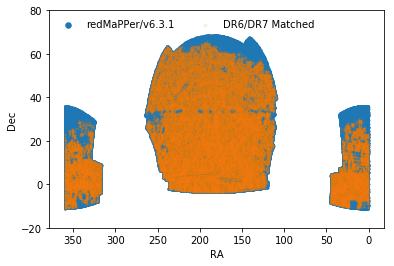

In [17]:
fig, ax = plt.subplots()
ax.scatter(rmcenall['RA_SDSS'], rmcenall['DEC_SDSS'], s=1, label='redMaPPer/v6.3.1')
ax.scatter(rmcen['RA_SDSS'], rmcen['DEC_SDSS'], s=1, alpha=0.1, 
           marker='.', label='DR6/DR7 Matched')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.set_ylim(-20, 80)
ax.invert_xaxis()
lgnd = ax.legend(loc='upper left', frameon=False, fontsize=10, ncol=2)
for ll in lgnd.legendHandles:
    ll._sizes = [30]

### Unpack the candidate central galaxies from the satellites / members catalog.
We are not analyzing the full set of satellites.

In [18]:
%time rmsatall = read_redmapper(rmversion=rmversion, satellites=True, index=index)

Read 10735182 galaxies from /Users/ioannis/research/data/redmapper/v6.3.1/dr8_run_redmapper_v6.3.1_lgt5_catalog_members.fit
Read 10735182 galaxies from /Users/ioannis/research/data/redmapper/v6.3.1/redmapper-v6.3.1-lgt5-members-sdssWISEphot-dr14.fits
CPU times: user 7.89 s, sys: 8.22 s, total: 16.1 s
Wall time: 17.9 s


In [19]:
if index is None:
    satid = rmsatall['ID'].data
else:
    satid = rmsatall['ID'].data[index]
%time lssatall = read_legacysurvey(rmversion=rmversion, satellites=True, satid=satid, index=index)
assert(len(rmsatall) == len(lssatall))

Read 10735182 galaxies from /Users/ioannis/research/data/redmapper/v6.3.1/legacysurvey-dr6-members-v6.3.1-lgt5.fits
Read 10735182 galaxies from /Users/ioannis/research/data/redmapper/v6.3.1/legacysurvey-dr7-members-v6.3.1-lgt5.fits
  Found 7247037 galaxies with DR7 photometry.
  Found 611760 galaxies with both DR6+DR7 photometry.
  Using deeper DR6 photometry for 76695/611760 galaxies.
  Using DR6 for 2403168 galaxies without DR7 photometry.
A total of 1084977/10735182 galaxies (10.11%) have neither DR6 nor DR7 photometry.
CPU times: user 1min 6s, sys: 35.8 s, total: 1min 42s
Wall time: 1min 49s


In [20]:
def get_central_candidates(cen, sat, ls):
    """Create a hash table connecting, for each cluster, all the candidate 
    centrals' ID numbers to an index in the satellites catalog.  The clever 
    algorithm used here is by Chun-Hao To (Stanford).
    
    """
    import pandas as pd
    
    ncen, ncand = cen['ID_CENT'].shape

    #offset = sat['ID'].min()
    #g_index = dok_matrix( (np.max(sat['ID']) - offset + 1, 1), dtype=np.int )
    #g_index[sat['ID'] - offset] = np.array( range( len(sat) ) )[:, np.newaxis]
    
    # Create a DataFrame for the catalog of centrals.
    cen_temp = [cen['ID_CENT'][:, ii] for ii in range(ncand)]
    cen_temp.append(cen['MEM_MATCH_ID'])
    columns = ['ID_CENT_{}'.format(ii) for ii in range(ncand)]
    columns.append('MEM_MATCH_ID_CEN')
               
    cen_pd = pd.DataFrame.from_records(np.array(cen_temp).T, columns=columns)
    del cen_temp, columns

    # Create DataFrame for the satellites / members.
    sat_pd = pd.DataFrame.from_records(sat[['ID', 'MEM_MATCH_ID']].as_array())
    sat_pd['index'] = pd.Series(np.arange(len(sat)), index=sat_pd.index)

    # Create the mapping between them
    cengalindex = np.zeros_like(cen['ID_CENT'])
    pcen = np.zeros( len(sat) ).astype('f4')
    primary_central = np.zeros( len(sat) ).astype(bool)
    
    for ii in range(ncand):
        # Old algorithm which doesn't deal with duplicates correctly.
        #index = np.where( cen['ID_CENT'][:, ii] - offset >= 0 )[0]
        #cengalindex[index, ii] = g_index[cen['ID_CENT'][index, ii] - offset]
        merged = pd.merge(cen_pd, sat_pd, left_on=['ID_CENT_{}'.format(ii), 'MEM_MATCH_ID_CEN'], 
                          right_on=['ID', 'MEM_MATCH_ID'], suffixes=('_original','_matched'))
        cengalindex[:, ii] = merged['index']
        pcen[cengalindex[:, ii]] = cen['P_CEN'][:, ii]
        if ii == 0:
            primary_central[cengalindex[:, ii]] = True
        
    cengalindex = cengalindex.flatten()
        
    candcen = sat[cengalindex]
    candcen.add_column(Column(name='P_CEN', data=pcen[cengalindex]), index=1)
    candcen.add_column(Column(name='PRIMARY_CENTRAL', data=primary_central[cengalindex]), index=2)

    return candcen, ls[cengalindex]

In [21]:
%time rmcandcenall, lscandcenall = get_central_candidates(rmcenall, rmsatall, lssatall)

CPU times: user 15.2 s, sys: 9.17 s, total: 24.4 s
Wall time: 29.7 s


In [22]:
candcenmatched = select_legacysurvey(lscandcenall)
print('Identified {} / {} ({:.2f}%) candidate centrals with grz photometry and a match to redMaPPer.'.format(
    len(candcenmatched), len(lscandcenall), 100*len(candcenmatched)/len(lscandcenall)))
lscandcen = lscandcenall[candcenmatched]
#lscandcen

Identified 1404088 / 1980235 (70.91%) candidate centrals with grz photometry and a match to redMaPPer.


In [23]:
rmcandcen = rmcandcenall[candcenmatched]
rmcandcen

MEM_MATCH_ID,P_CEN,PRIMARY_CENTRAL,SDSS_OBJID,ID,RA_SDSS,DEC_SDSS,PETROMAGGIES [5],PETROMAGGIES_IVAR [5],MODELMAGGIES [5],MODELMAGGIES_IVAR [5],CMODELMAGGIES [5],CMODELMAGGIES_IVAR [5],WISE_NANOMAGGIES [2],WISE_NANOMAGGIES_IVAR [2],EXTINCTION [5],PETROR50 [5],Z,RA_REDMAPPER,DEC_REDMAPPER,R,P,PFREE,THETA_I,THETA_R,MODEL_MAG [5],MODEL_MAGERR [5],IMAG,IMAG_ERR,ZRED,ZRED_E,ZRED2,ZRED2_E,CHISQ,ZSPEC,PHOTOID
int32,float32,bool,int64,int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64
1,0.874838,True,1237662340012638224,25404293,239.583335437,27.2334095464,95.8095 .. 4284.27,0.000654984 .. 1.62822e-06,62.9277 .. 3331.97,0.121141 .. 0.00400068,29.5241 .. 3215.09,0.532083 .. 0.00430256,39647.6 .. 42470.3,0.000414198 .. 4.17227e-05,0.187233 .. 0.0557857,101.315 .. 25.6271,0.0948307,239.583329069,27.2334129178,0.0,1.0,1.0,1.0,1.0,17.7673 .. 13.6197,0.0495718 .. 0.00515177,13.979,0.00269815,0.0976015,0.00598646,0.0982965,0.0055942,17.1603,0.0908067,39270301200850016
1,0.125147,False,1237662340012572780,25403990,239.555396456,27.2481270395,61.4261 .. 1331.72,0.0348051 .. 0.00109733,54.6554 .. 2135.72,0.176851 .. 0.00645443,69.2441 .. 1744.92,0.11109 .. 0.00968203,25203.0 .. 25951.0,0.000618997 .. 6.24648e-05,0.186098 .. 0.0554474,13.0335 .. 6.15525,0.0948307,239.555404995,27.2481222018,0.129942,0.841401,1.0,1.0,1.0,17.9276 .. 14.1039,0.0472372 .. 0.00632779,14.5012,0.00306871,0.100387,0.00883695,0.100834,0.00826606,11.7572,0.0965052,39270301200840108
1,1.04664e-06,False,1237662340012573070,25404032,239.526767458,27.2741124338,19.3957 .. 768.687,0.427881 .. 0.00567199,21.947 .. 868.024,1.65491 .. 0.0477927,22.2429 .. 849.75,1.58749 .. 0.0489542,10199.3 .. 11262.3,0.0030825 .. 0.000276136,0.18493 .. 0.0550995,2.20161 .. 2.17408,0.0948307,239.526774145,27.2741083512,0.291261,0.979641,1.0,1.0,1.0,18.9167 .. 15.0804,0.0384537 .. 0.00572152,15.5301,0.00337974,0.101323,0.00773744,0.101707,0.00724016,6.34858,0.0868405,39270301200840398
1,5.36843e-07,False,1237662340012573171,25404056,239.559626085,27.2721074392,13.895 .. 560.182,0.244728 .. 0.0124713,18.1376 .. 626.92,1.54564 .. 0.0543395,15.0742 .. 558.359,2.2556 .. 0.0687947,8176.26 .. 8991.2,0.00275354 .. 0.000240662,0.187077 .. 0.055739,2.00229 .. 2.42804,0.0948307,239.559634173,27.2721026726,0.198365,0.984712,1.0,1.0,1.0,19.1302 .. 15.4325,0.0481456 .. 0.00742939,15.8785,0.00397304,0.111793,0.00832922,0.111714,0.00782687,7.54977,0.095399,39270301200840499
2,0.985673,True,1237651715872325879,3352952,250.082552977,46.7114748935,19.338 .. 200.168,0.0739838 .. 0.000865781,10.7362 .. 460.244,0.486459 .. 0.0149121,31.4261 .. 274.856,0.074432 .. 0.0401029,7234.43 .. 8665.86,0.00300798 .. 0.000288756,0.102034 .. 0.0304007,10.4942 .. 2.44081,0.232764,250.082548387,46.7115313536,0.0,1.0,1.0,1.0,1.0,19.7931 .. 15.8147,0.144956 .. 0.0193181,16.2903,0.0075439,0.263556,0.00704976,0.261356,0.00743829,22.2347,-1.0,14530301500570247
2,0.0114961,False,1237651715872325916,3352959,250.098548745,46.7027823499,3.98637 .. 194.447,0.386962 .. 0.00806548,3.4422 .. 205.067,3.25069 .. 0.0972556,2.834 .. 191.094,5.07264 .. 0.112195,3432.12 .. 4495.08,0.00600671 .. 0.000549043,0.101749 .. 0.030316,5.59484 .. 2.14346,0.232764,250.098546112,46.7028374918,0.13021,0.995656,1.0,1.0,1.0,21.0326 .. 16.6926,0.174486 .. 0.016977,17.0278,0.00752074,0.257058,0.00920468,0.254884,0.00973178,3.05936,0.229257,14530301500570284
2,0.00159039,False,1237651715872325903,3352955,250.099496878,46.7146562842,4.9263 .. 130.104,1.14792 .. 0.0409116,3.98904 .. 145.272,5.7642 .. 0.184091,5.135 .. 131.498,3.52798 .. 0.225415,2205.33 .. 2760.13,0.00843746 .. 0.000746976,0.103265 .. 0.0307674,1.89067 .. 1.24823,0.232764,250.099493523,46.7147127564,0.112059,0.656638,1.0,1.0,1.0,20.8812 .. 17.0662,0.113142 .. 0.0174182,17.3469,0.00749281,0.208166,0.0080914

### Additional sample cuts

Exclude the sources with the shallowest DR6/DR7 *grz* photometry based on the estimated point-source depth.

In [24]:
band = ['G', 'R', 'Z']
targdepth = [24.0, 23.4, 22.5] # target 5-sigma depth
meddepth, P10depth = np.zeros((3)), np.zeros((3))

In [25]:
#dd = 22.5-2.5*np.log10(5/np.sqrt(lscen['PSFDEPTH_Z']))
#nobs = lscen['NOBS_G']
#_ = plt.hist(dd, bins=100)
#print(dd.min(), np.sum(dd < 22), np.sum(nobs <= 1))

g depth: P10: 24.115, median = 24.581, target = 24.000
r depth: P10: 23.602, median = 24.082, target = 23.400
z depth: P10: 22.930, median = 23.246, target = 22.500


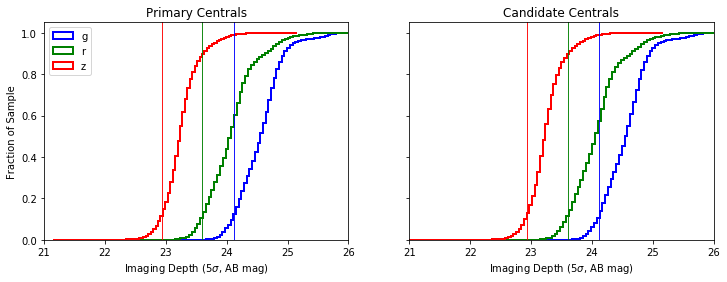

In [26]:
color = ('blue', 'green', 'red')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
for ii, (tt, bb, col) in enumerate( zip( targdepth, band, color ) ):
    cendepth = 22.5 - 2.5 * np.log10( 5 / np.sqrt(lscen['PSFDEPTH_{}'.format(bb)]) )
    candcendepth = 22.5 - 2.5 * np.log10( 5 / np.sqrt(lscandcen['PSFDEPTH_{}'.format(bb)]) )
    
    meddepth[ii] = np.percentile(cendepth, [50])
    P10depth[ii] = np.percentile(cendepth, [10])
    print('{} depth: P10: {:.3f}, median = {:.3f}, target = {:.3f}'.format(
        bb.lower(), P10depth[ii], meddepth[ii], tt))
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        # centrals
        nn, bins, patches = ax1.hist(cendepth, bins=100, histtype='step', cumulative=True,
                                     label=bb.lower(), normed=True, color=col, lw=2)
        patches[0].set_xy(patches[0].get_xy()[:-1]) # delete the last point
        # candidate centrals
        nn, bins, patches = ax2.hist(candcendepth, bins=100, histtype='step', cumulative=True,
                                     label=bb.lower(), normed=True, color=col, lw=2)
        patches[0].set_xy(patches[0].get_xy()[:-1]) # delete the last point
    
    #ax.axvline(x=tt, ls='--', color=col, lw=2, alpha=1.0)
    #ax.axvline(x=meddepth[ii], ls='-', color=col, lw=1, alpha=0.9)
    for ax in (ax1, ax2):
        ax.axvline(x=P10depth[ii], ls='-', color=col, lw=1, alpha=0.9)

ax1.legend(loc='upper left')
ax1.set_ylabel('Fraction of Sample')
ax1.set_title('Primary Centrals')
ax2.set_title('Candidate Centrals')
for ax in (ax1, ax2):
    ax.set_xlabel('Imaging Depth (5$\sigma$, AB mag)')
    ax.set_xlim(21, 26)
    
fig.subplots_adjust(hspace=0.01)

In [29]:
depthcut = (23.5, 23.0, 22.0)
cendepthcut = np.ones(len(lscen)).astype(bool)
candcendepthcut = np.ones(len(lscandcen)).astype(bool)
for ii, bb in enumerate(['G', 'R', 'Z']):
    cendepth = 22.5 - 2.5 * np.log10( 5 / np.sqrt(lscen['PSFDEPTH_{}'.format(bb)]) )
    candcendepth = 22.5 - 2.5 * np.log10( 5 / np.sqrt(lscandcen['PSFDEPTH_{}'.format(bb)]) )
    cendepthcut *= cendepth > depthcut[ii]
    candcendepthcut *= candcendepth > depthcut[ii]
    #cendepthcut *= cendepth > p10depth[ii]
    #satdepthcut *= satdepth > p10depth[ii]
print('{} / {} ({:.2f}%) centrals pass the depth cuts in all three bands.'.format(
    np.sum(cendepthcut), len(lscen), 100*np.sum(cendepthcut)/len(lscen)))
print('{} / {} ({:.2f}%) candidate centrals pass the depth cuts in all three bands.'.format(
    np.sum(candcendepthcut), len(lscandcen), 100*np.sum(candcendepthcut)/len(lscandcen)))

293067 / 293328 (99.91%) centrals pass the depth cuts in all three bands.
1402762 / 1404088 (99.91%) candidate centrals pass the depth cuts in all three bands.


### Cut and join the redMaPPer (central & satellite) and LS catalogs

In [30]:
rmcendeep = rmcen[cendepthcut]
lscendeep = lscen[cendepthcut]
cen = hstack( (rmcendeep, lscendeep) )

In [31]:
candcen = hstack( (rmcandcen[candcendepthcut], lscandcen[candcendepthcut]) )
del rmcandcen, lscandcen

In [32]:
def _normhist(xx, ax, label=None, alpha=1.0, lw=2, bins=100):
    _, _, _ = ax.hist(xx, weights=np.ones_like(xx) / float(len(xx)), bins=bins, 
                      histtype='step', label=label, lw=lw, alpha=alpha)

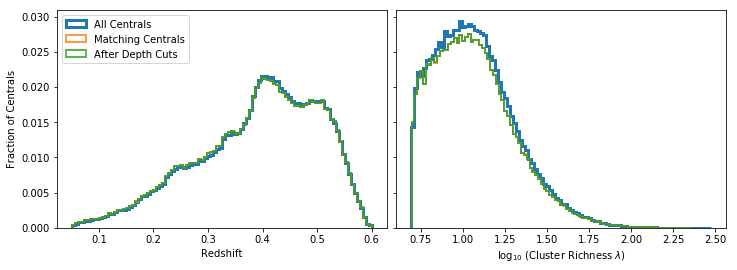

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

_normhist(rmcenall['Z'], ax1, label='All Centrals', lw=3)
_normhist(rmcen['Z'], ax1, label='Matching Centrals', alpha=0.8)
_normhist(rmcendeep['Z'], ax1, label='After Depth Cuts', alpha=0.8)
ax1.set_xlabel('Redshift')
ax1.set_ylabel('Fraction of Centrals')
ax1.legend(loc='upper left')

_normhist(np.log10(rmcenall['LAMBDA_CHISQ']), ax2, lw=3)
_normhist(np.log10(rmcen['LAMBDA_CHISQ']), ax2, alpha=0.8)
_normhist(np.log10(rmcendeep['LAMBDA_CHISQ']), ax2, alpha=0.8)
ax2.set_xlabel('$\log_{10}$ (Cluster Richness $\lambda$)')
#ax2.set_ylabel('Fraction of Galaxies')
fig.subplots_adjust(wspace=0.03)

### Get the total area subtended by the final sample.

In [34]:
def get_area(nside=256, qaplot=True):
    """Get the unique area of the sample."""
    
    areaperpix = hp.nside2pixarea(nside, degrees=True)
    samplepix = radec2pix(nside, cen['RA'].data, cen['DEC'].data)
    print('Subdividing the sample into nside={} healpixels with area={:.4f} deg2 per pixel.'.format(
        nside, areaperpix))

    outpixmap = []
    for dr, release in zip( ('dr6.0', 'dr7.1'), (6000, 7000) ):
        # Read the pixel weight map which quantifies the imaging footprint
        pixfile = os.path.join( legacyhalos.io.sample_dir(), 'pixweight-{}-0.22.0.fits'.format(dr) )
        pixmap = Table(fitsio.read(pixfile))
        pixmap['DR'] = dr.upper()
    
        these = cen['RELEASE'].data == release
        thesepix = np.unique(samplepix[these])
    
        # Only keep non-empty healpixels.
        keep = ( (pixmap['FRACAREA'][thesepix] > 0) * 
                (pixmap['PSFDEPTH_G'][thesepix] > 0) * # p10depth[0]) * 
                (pixmap['PSFDEPTH_R'][thesepix] > 0) * # p10depth[1]) * 
                (pixmap['PSFDEPTH_Z'][thesepix] > 0)   # p10depth[2]) 
               )
        outpixmap.append(pixmap[thesepix][keep])
    outpixmap = vstack(outpixmap)
    
    if False:
        print('Clamping FRACAREA at unity!')
        toobig = outpixmap['FRACAREA'] > 1
        if np.sum(toobig) > 0:
            outpixmap['FRACAREA'][toobig] = 1.0

    # Don't double-count area, where DR6 and DR7 overlap.
    _, keep = np.unique(outpixmap['HPXPIXEL'], return_index=True)
    dup = np.delete( np.arange(len(outpixmap)), keep )
    
    # Code to double-check for duplicates and to ensure every object 
    # has been assigned a healpixel.
    # for pp in outpixmap['HPXPIXEL'][keep]:
    #     if np.sum( pp == outpixmap['HPXPIXEL'][keep] ) > 1:
    #         print('Duplicate!')
    #         import pdb ; pdb.set_trace()
    #     if np.sum( pp == samplepix ) == 0:
    #         print('Missing healpixel!')
    #         import pdb ; pdb.set_trace()
    
    area = np.sum(outpixmap['FRACAREA'][keep]) * areaperpix
    duparea = np.sum(outpixmap['FRACAREA'][dup]) * areaperpix

    if qaplot:
        uu = np.in1d(samplepix, outpixmap['HPXPIXEL'][keep])
        dd = np.in1d(samplepix, outpixmap['HPXPIXEL'][dup])
        fig, ax = plt.subplots()
        ax.scatter(cen['RA'][uu], cen['DEC'][uu], s=1, marker='s',
                   label=r'Unique: {:.1f} deg$^{{2}}$'.format(area))
        ax.scatter(cen['RA'][dd], cen['DEC'][dd], s=1, marker='s',
                   label=r'Overlapping: {:.1f} deg$^{{2}}$'.format(duparea))
        ax.set_xlim(0, 360)
        ax.set_ylim(-15, 80)
        #ax.legend(loc='upper right', fontsize=12, frameon=False)
        ax.invert_xaxis()
        lgnd = ax.legend(loc='upper left', frameon=False, fontsize=10, ncol=2)
        for ll in lgnd.legendHandles:
            ll._sizes = [30]        
        
    return area, duparea, outpixmap[keep]

Subdividing the sample into nside=256 healpixels with area=0.0525 deg2 per pixel.
Unique area = 7181.307 deg2
Overlapping area = 1.201 deg2


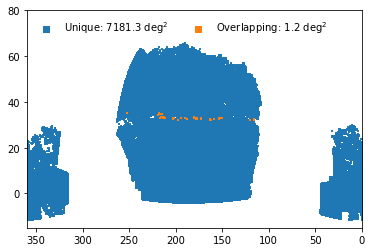

In [35]:
area, duparea, pixmap = get_area()
print('Unique area = {:.3f} deg2\nOverlapping area = {:.3f} deg2'.format(area, duparea))

In [36]:
len(pixmap), len(np.unique(pixmap['HPXPIXEL']))

(138045, 138045)

### Create jackknife samples

In [37]:
def jackknife_samples(pixmap, nside_pixmap=256, nside_jack=4):
    """Split the sample into ~equal area chunks and write out a table.
    
    """
    from astropy.io import fits
    
    area_jack = hp.nside2pixarea(nside_jack, degrees=True)
    area_pixmap = hp.nside2pixarea(nside_pixmap, degrees=True)
    print('Jackknife nside = {} with area = {:.3f} deg2'.format(nside_jack, area_jack))
    
    pix_jack = radec2pix(nside_jack, cen['RA'].data, cen['DEC'].data)
    pix_pixmap = radec2pix(nside_pixmap, cen['RA'].data, cen['DEC'].data)
    
    upix_jack = np.unique(pix_jack)
    upix_jack = upix_jack[np.argsort(upix_jack)]
    npix = len(upix_jack)
    
    ra_jack, dec_jack = pix2radec(nside_jack, upix_jack)
    
    out = Table()
    out['HPXPIXEL'] = upix_jack
    out['RA'] = ra_jack
    out['DEC'] = dec_jack
    out['AREA'] = np.zeros(npix).astype('f4')
    out['NCEN'] = np.zeros(npix).astype('int')
    
    for ii, pp in enumerate(upix_jack):
        these = np.where( pp == pix_jack )[0]
        indx = np.where( np.in1d( pixmap['HPXPIXEL'].data, pix_pixmap[these] ) )[0]
        uindx = np.unique(indx)
        #print(pp, len(indx), len(uindx))

        out['AREA'][ii] = np.sum(pixmap['FRACAREA'][indx].data) * area_pixmap
        out['NCEN'][ii] = len(these)
        
        #if ii == 4:
        #    rbig, dbig = pix2radec(nside_jack, pp)
        #    rsmall, dsmall = pix2radec(nside_pixmap, pixmap['HPXPIXEL'][indx].data)
        #    rgal, dgal = sample['RA'][these], sample['DEC'][these]
        #    plt.scatter(rgal, dgal, s=3, marker='o', color='green')
        #    plt.scatter(rsmall, dsmall, s=3, marker='s', color='blue')
        #    plt.scatter(rbig, dbig, s=75, marker='x', color='k')
        #    plt.show()
        #    import pdb ; pdb.set_trace() 
        
    print('Writing {}'.format(jackfile))
    hx = fits.HDUList()
    hdu = fits.convenience.table_to_hdu(out)
    hdu.header['EXTNAME'] = 'JACKKNIFE'
    hdu.header['NSIDE'] = nside_jack
    hx.append(hdu)
    hx.writeto(jackfile, overwrite=True)

    return out

In [38]:
nside_jack = 4
jack = jackknife_samples(pixmap, nside_jack=nside_jack)
njack = len(jack)
jack

Jackknife nside = 4 with area = 214.859 deg2
Writing /Users/ioannis/research/projects/legacyhalos/sample/legacyhalos-jackknife-dr6-dr7.fits


HPXPIXEL,RA,DEC,AREA,NCEN
int64,float64,float64,float32,int64
0,45.0,9.59406822686,11.5624,446
2,33.75,19.4712206345,23.8349,868
8,22.5,30.0,24.5288,833
16,135.0,9.59406822686,167.074,6713
17,146.25,19.4712206345,173.287,7258
18,123.75,19.4712206345,138.563,5126
19,135.0,30.0,156.924,6649
20,157.5,30.0,171.558,7342
21,168.75,41.8103148958,172.842,7077


Check: total area = 7181.307, total number of galaxies = 293067
Mean / median area per pixel = 97.045 / 102.775 deg2
Mean / median number of centrals per pixel = 3960 / 3896


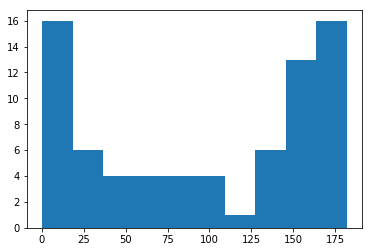

In [39]:
print('Check: total area = {:.3f}, total number of galaxies = {}'.format(
    np.sum(jack['AREA']), np.sum(jack['NCEN'])))
print('Mean / median area per pixel = {:.3f} / {:.3f} deg2'.format(
    np.mean(jack['AREA']), np.median(jack['AREA'])))
print('Mean / median number of centrals per pixel = {:.0f} / {:.0f}'.format(
    np.mean(jack['NCEN']), np.median(jack['NCEN'])))
_ = plt.hist(jack['AREA'])

Visualize the jackknife samples.

Text(0,0.5,'Dec')

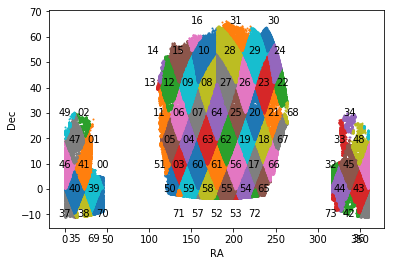

In [40]:
jackpix = legacyhalos.misc.radec2pix(nside_jack, cen['RA'].data, cen['DEC'].data)
jack_ra, jack_dec = legacyhalos.misc.pix2radec(nside_jack, jack['HPXPIXEL'])
fig, ax = plt.subplots()
for ii in range(njack):
    indx = np.where( jack['HPXPIXEL'][ii] == jackpix )[0]
    ax.scatter(cen['RA'][indx], cen['DEC'][indx], s=1)
    ax.text(jack_ra[ii], jack_dec[ii], '{:02d}'.format(ii), 
            va='center', ha='center')
    #ax.text(jack_ra[ii], jack_dec[ii], '{:02d}'.format(jack['HPXPIXEL'][ii]))    
ax.set_xlabel('RA')
ax.set_ylabel('Dec')

### Write out the final samples.

In [41]:
print('Writing {}'.format(cenfile))
cen.write(cenfile, overwrite=True)

Writing /Users/ioannis/research/projects/legacyhalos/sample/legacyhalos-centrals-dr6-dr7.fits


In [42]:
print('Writing {}'.format(candcenfile))
candcen.write(candcenfile, overwrite=True)

Writing /Users/ioannis/research/projects/legacyhalos/sample/legacyhalos-candidate-centrals-dr6-dr7.fits
